# ECS784 Lab 5 Part 1
# Supervised Learning Case Study

* This provides a case study of a Supervised Learning Data Analysis project.

### Version History

 * v1 20/01/2023: merged Data processing and Machine Learning parts (from 2022/3 ECS784W course) and added hyperparameter and PCA component selection to create first version for 2022/3 ECS784P Data Analytics course
 * v2.1 09/02/2024: change feature_names argument type to be a list in call to plot_tree to prevent Python error
 * v2.11 15/02/2025: check works with latest versions of libraries without producing any errors, in particular, increase number of iterations in Logistic Regression to prevent "failure to converge" warnings
 


## 1. The Data Analysis Problem
   
* Loan prediction data set (not sure where this data came from - student projects need a reference though)
* The purpose is to predict whether the lender should approve an application for loan by a given individual.
* This is a standard supervised classification task.
   
Variable | Description
----------|--------------
Loan_ID | Unique Loan ID
Gender | Male/ Female
Married | Applicant married (Y/N)
Dependents | Number of dependents
Education | Applicant Education (Graduate/ Under Graduate)
Self_Employed | Self employed (Y/N)
ApplicantIncome | Applicant income
CoapplicantIncome | Coapplicant income
LoanAmount | Loan amount in thousands
Loan_Amount_Term | Term of loan in months
Credit_History | credit history meets guidelines
Property_Area | Urban/ Semi Urban/ Rural
Loan_Status | Loan approved (Y/N)

## 2. Exploring the Data Using Pandas

### 2.1 Import the necessary modules and read the data

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns                   # a visualisation library we have not covered in previous labs
from matplotlib import pyplot as plt    # we will also use the matplotlib visualisation library
# import warnings
# warnings.simplefilter('ignore', category=UserWarning)  # suppresses warning message from Seaborn

# command below ensures matplotlib output can be included in Notebook

%matplotlib inline

In [5]:
df = pd.read_csv('Loan_prediction_case_study.csv') # load the data set into a dataFrame

### 2.2 Exploring size of data and variable types

* df**.columns** lists the columns
* df**.dtypes** lists the underlying NumPy variable types, string/categorical go to object type for example. Pandas "guesses" them from the values it finds in the data file.
* df**.shape** gives rows and columns
* df**.index** gives an index into the rows - initially set to be the row number when it is read from the file. We are not using it here, but you can set it to be something more useful for other applications e.g. with this data, you might well set the index as LoanId so you can easily access the details by LoanId.
   * Can use **df.iloc[*list of row ids*]** - OK to look at a few rows, but inefficient so not recommended to loop through rows and use this to access individual rows
* individual columns accessed by **df[*colname*]** which is a Pandas series object

In [7]:
df.columns # Listing the dataframe columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [8]:
df.dtypes # returns the datatype of each column - Pandas sets type from values it finds in data file

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [9]:
df.shape # returns the shape of data - 614 rows, and 13 columns

(614, 13)

**QUESTION (optional, to think about): Does this seem a reasonable size for the dataset at first glance?**

1. No, there are too many columns.
    - INCORRECT: 12 feature variables is not too many
2. No, there are too few columns.
    - INCORRECT: 12 feature variables is not too few
3. Yes, it seems exploring more at least.
    - CORRECT: Between 5 and 25 or so is often a good number of feature variables to use,
and (number of rows / number of columns) is greater than 5 which is reasonable too.

### 2.3 Preliminary exploration of values in the data

* **df.head()** or **df.tail()** to look at first or last few rows
* **df.describe()** provide more information about the numeric variables
* **df.info()** another way of viewing variable types but also numbers of missing values
* **df.iloc(*indexid*)** can be used to look at individual rows

In [12]:
df.head() # Let's view the first few rows of the dataFrame

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [13]:
df.describe() # Let's view the description of the numerical values in the data set (does not show categorical variables)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


**QUESTION (optional, to think about): One of these variables looks like it should not be a continuous variable, which?**
 1. Loan_Amount because Count looks low
    - INCORRECT: It is only lower than some other columns because it contains some null
values - not a problem as long as we deal with them somehow.
 2. CoapplicantIncome because 25% percentile is 0.0
    - INCORRECT: No, this is not necessarily a problem, it just means that more than
25% of the values are zero, but the 50%, 75% and max values indicate that the other
values are continuous values.
 3. Credit_History because I don't understand how that could be a real number
    - CORRECT: The fact that the min value is 0.0, and the quartiles and the max value
are 1.0 strongly suggests this is a variable that just takes two values: 0 and 1. Also, it
seems strange for one number to represent a credit history - it is more likely that 0 or 1
just indicates whether the person has a credit history or not.

In [15]:
df.info() # This pandas function returns the data types associated with each variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [16]:
print('Credit_History was dtype: {}'.format(df['Credit_History'].dtype))
df = df.astype({'Credit_History': str})  # treat Credit_History as a categorical variable
print('Credit_History is now dtype: {}'.format(df['Credit_History'].dtype))

Credit_History was dtype: float64
Credit_History is now dtype: object


In [17]:
print('The row index is {}'.format(df.index))  # an index into the rows - initialised to row numbers
print('Can use iloc to access individual rows:\n{}'.format(df.iloc[[0, -1]]))  # access first and last row

The row index is RangeIndex(start=0, stop=614, step=1)
Can use iloc to access individual rows:
      Loan_ID  Gender Married Dependents Education Self_Employed  \
0    LP001002    Male      No          0  Graduate            No   
613  LP002990  Female      No          0  Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               5849                0.0         NaN             360.0   
613             4583                0.0       133.0             360.0   

    Credit_History Property_Area Loan_Status  
0              1.0         Urban           Y  
613            0.0     Semiurban           N  


### 2.4 Distributions of categorical values

* **df[*colname*].unique()** lists unique values
* **df[*colname*].value_counts()** gives number of rows in each category
  * how skewed is data? 
  * any bias in the data?
* ***series*.plot()** can plot a series, e.g. value_counts() in one line
* Can use higher-level graphics library such as **Seaborn** but can be tricky to customise

In [19]:
print('Loan_ID is non-numeric and is unique for each row: {} different values ... so we can drop it'
      .format(len(df['Loan_ID'].unique())))
df = df.drop(['Loan_ID'], axis=1)

Loan_ID is non-numeric and is unique for each row: 614 different values ... so we can drop it


In [20]:
print('Values and counts for Loan_Status are:\n{}'.format(df['Loan_Status'].value_counts()))
print('Values and normalised counts for Loan_Status are:\n{}'.format(df['Loan_Status'].value_counts(normalize=True)))

Values and counts for Loan_Status are:
Loan_Status
Y    422
N    192
Name: count, dtype: int64
Values and normalised counts for Loan_Status are:
Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64


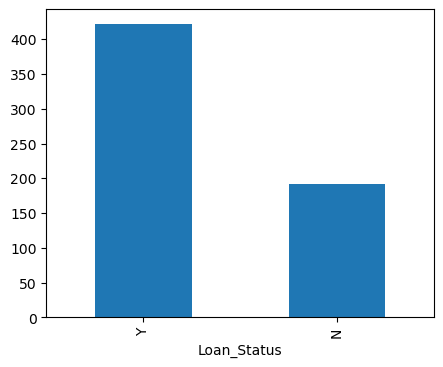

In [21]:
# Can plot counts using Pandas in-built functions (which calls matplotlib functions)
df['Loan_Status'].value_counts().plot.bar(figsize=(5, 4)) 
plt.show()

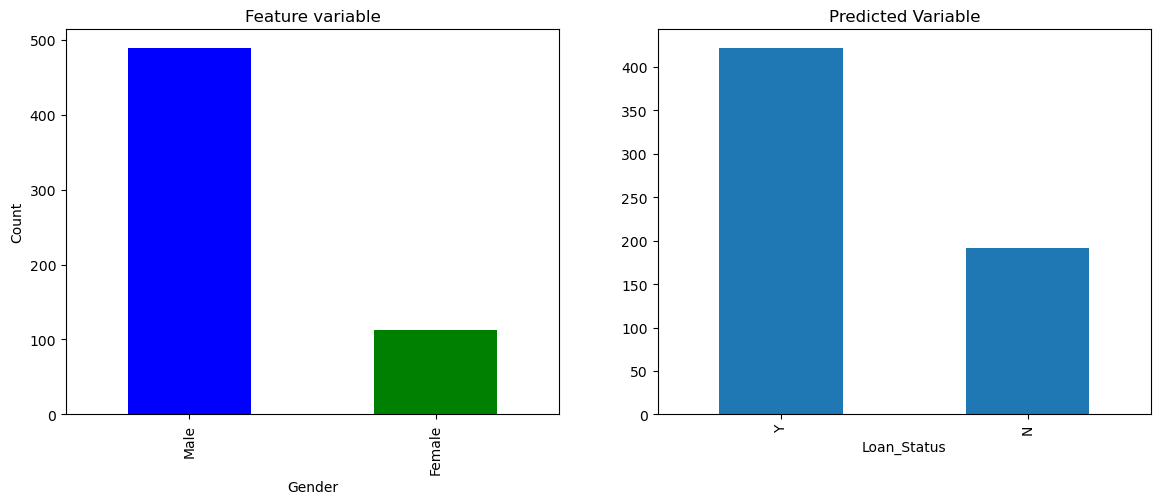

In [22]:
# you can use arguments and matplotlib calls to have more control over plots 
# e.g. have a grid layout, specify labels, colours and title

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
df['Gender'].value_counts().plot(ax=axes[0], kind='bar',
                                title='Feature variable', color=['b', 'g'],
                                ylabel = 'Count', xlabel='Gender')
df['Loan_Status'].value_counts().plot(ax=axes[1], kind='bar',
                                      title='Predicted Variable', xlabel='Loan_Status') 
plt.show()

Pandas melt function produces a "long-form" dataframe required by catplot():
  variable value
0   Gender  Male
1   Gender  Male


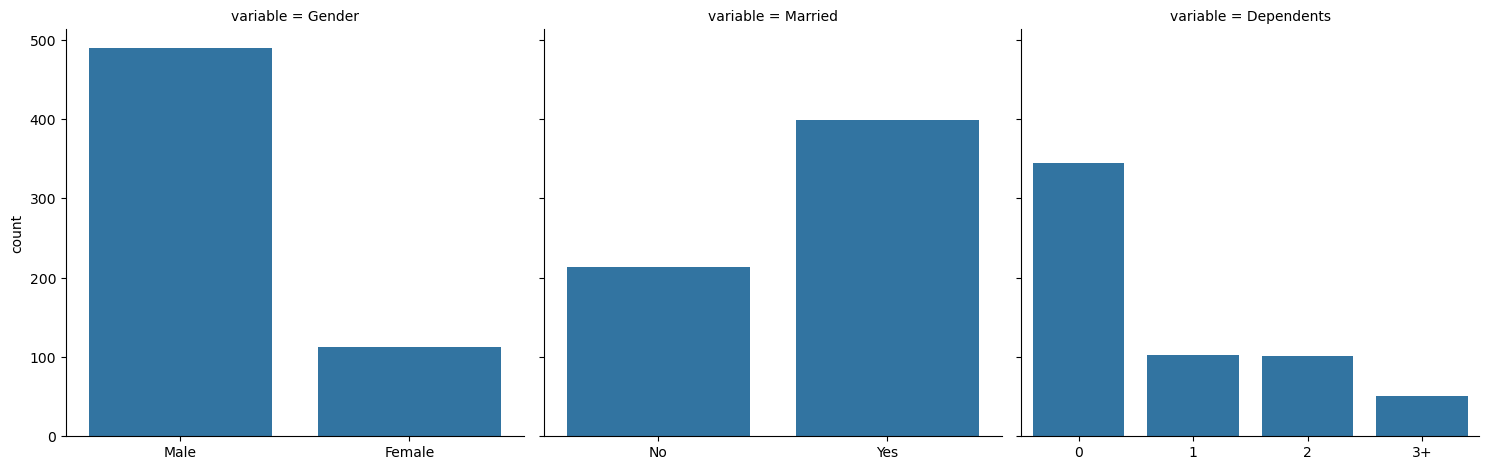

In [23]:
data = pd.melt(df[['Gender', 'Married', 'Dependents']])
print('Pandas melt function produces a "long-form" dataframe required by catplot():\n{}'.format(data.head(2)))
g = sns.catplot(data=data, kind='count', col='variable', x='value', y=None, sharex=False)
g.set_axis_labels(x_var='')  # suppress the x-axis labels, the defaults are not very useful
plt.show()

### 2.5 Distributions of continuous variables

* use ***Series*.plot()** again to look at distribution
   * can try kind= hist, density or box for example
   * is it skewed, long-tailed, outliers?

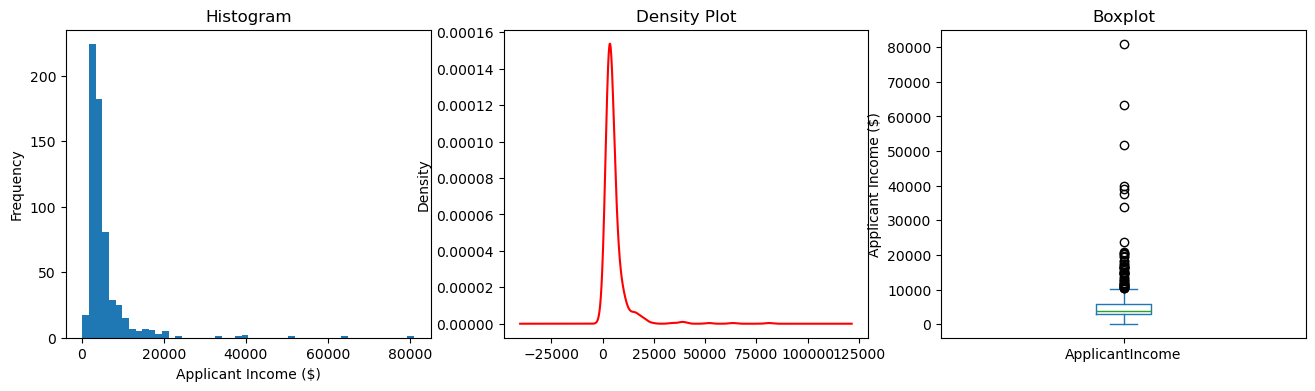

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
df['ApplicantIncome'].plot(kind='hist', bins=50, ax=axes[0], xlabel="Applicant Income ($)",
                           title="Histogram")
df['ApplicantIncome'].plot(kind='density', color='r', ax=axes[1], title='Density Plot')
df['ApplicantIncome'].plot(kind='box', ax=axes[2], ylabel='Applicant Income ($)',
                           xlabel='', title='Boxplot')
plt.show()

### 2.6 Bivariate Analysis - does a categorical variable look predictive of loan_status?

* use **pd.crosstab(column1, column2)** to get counts for combinations of values which it returns as small DataFrame, which we normalise
* we can then use **df.plot()** to plot this 2-D DataFrame as a stacked bar chart straightaway


Counts for Self_Employed vs Loan_Status are:
Loan_Status      N    Y
Self_Employed          
No             157  343
Yes             26   56

Normalised counts for Self_Employed vs Loan_Status are:
Loan_Status           N         Y
Self_Employed                    
No             0.314000  0.686000
Yes            0.317073  0.682927

Normalised counts for Dependents vs Loan_Status are:
Loan_Status         N         Y
Dependents                     
0            0.310145  0.689855
1            0.352941  0.647059
2            0.247525  0.752475
3+           0.352941  0.647059


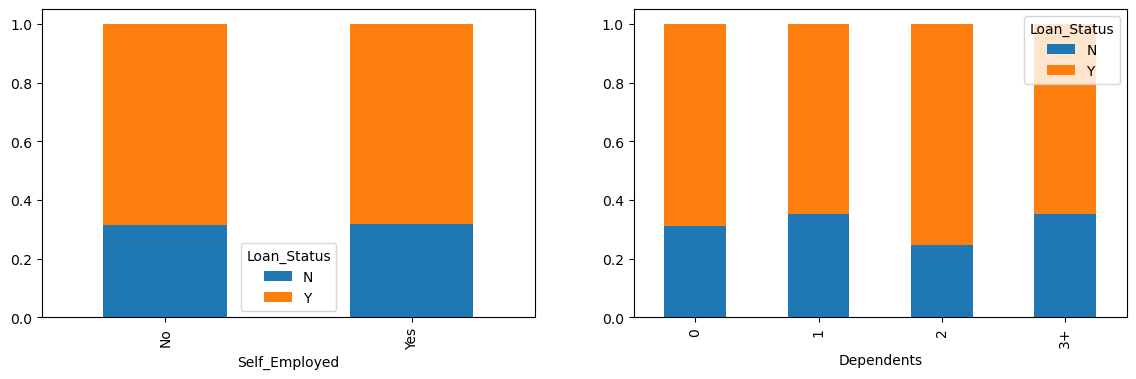

In [27]:
Self_Employed=pd.crosstab(df['Self_Employed'],df['Loan_Status'])
print('Counts for Self_Employed vs Loan_Status are:\n{}'.format(Self_Employed))

# Do some normalisation so that we divide the counts for Self_employed = No, and
# Self_Employed = Yes so they each add up to 1. Note we use NumPy style sum and
# division operations to do this. This allows us to see the ratios of Loan_status
# N to Y for each value of self_employed on the plots

Self_Employed = Self_Employed.div(Self_Employed.sum(1).astype(float), axis=0)
print('\nNormalised counts for Self_Employed vs Loan_Status are:\n{}'.format(Self_Employed))

# Do the same for Dependents

Dependents = pd.crosstab(df['Dependents'],df['Loan_Status'])
Dependents = Dependents.div(Dependents.sum(1).astype(float), axis=0)
print('\nNormalised counts for Dependents vs Loan_Status are:\n{}'.format(Dependents))

# Lets plot them out

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
Self_Employed.plot(kind="bar",stacked=True, ax=axes[0])
Dependents.plot(kind="bar",stacked=True, ax=axes[1])
plt.show()

**QUESTION (optional, to think about): which of Self_Employed and/or Dependents might be a good predictive variable?**
 
 1. Self_Employed, it looks nicely balanced.
    - INCORRECT: It is balanced in that the proportion of people given a loan or not given
a loan is similar for both self-employed is “No” and “Yes”. But this means Self_employed
is not very strongly predictive of loan_status.
 2. Dependents, as it seems to affect the loan_status more.
    - CORRECT: The proportion of people given a loan or not (the fraction of yellow and
blue in each bar) does change with the number of dependents so it is likely a good
predictor of whether people get a loan or not.
 3. Neither, they both seem quite skewed.
    - INCORRECT: It is true that the data is “skewed” in that in all cases loan_status=
Y is bigger than the loan_status = N, but this is irrelevant. What is important is that
this proportion changes for different values of the feature variable.

### 2.7 Bivariate Analysis - does a continuous variable look predictive of loan_status

* can try **df.plot(column=*column1*, by=*column2*, ...)**

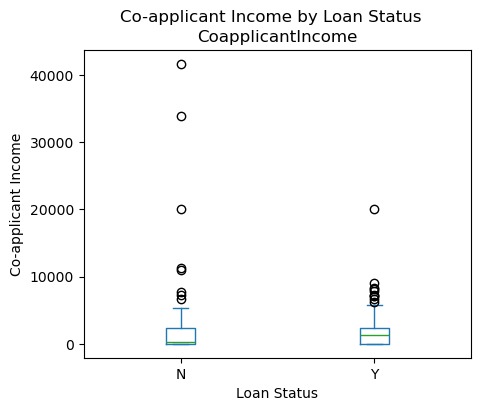

In [30]:
df.plot(column="CoapplicantIncome", by='Loan_Status', kind='box', subplots=False, 
        xlabel='Loan_Status', ylabel="Co-applicant Income", 
        title="Co-applicant Income by Loan Status", figsize=(5, 4))
plt.xlabel('Loan Status')  # for some reason, xlabel arg on df.plot didn't work
plt.show()

* can use **df.groupby(*target_col*)[*feature_col*].mean()** to look at mean of continuous variable and see if mean of feature variable differs for different target variable values

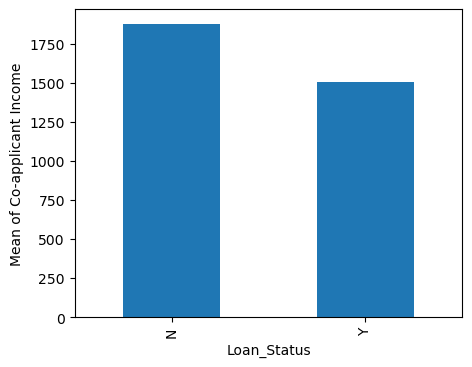

In [32]:
df.groupby('Loan_Status')['CoapplicantIncome'].mean().plot(kind='bar', 
                                                           ylabel='Mean of Co-applicant Income',
                                                           figsize=(5, 4))
plt.show()

* or discretise continuous variables using the **pd.cut(*series_to_dicretise*)**

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term
count       614.000000         614.000000  592.000000         600.00000
mean       5403.459283        1621.245798  146.412162         342.00000
std        6109.041673        2926.248369   85.587325          65.12041
min         150.000000           0.000000    9.000000          12.00000
25%        2877.500000           0.000000  100.000000         360.00000
50%        3812.500000        1188.500000  128.000000         360.00000
75%        5795.000000        2297.250000  168.000000         360.00000
max       81000.000000       41667.000000  700.000000         480.00000
LoanAmount_bin
Average    358
Low        154
High        80
Name: count, dtype: int64


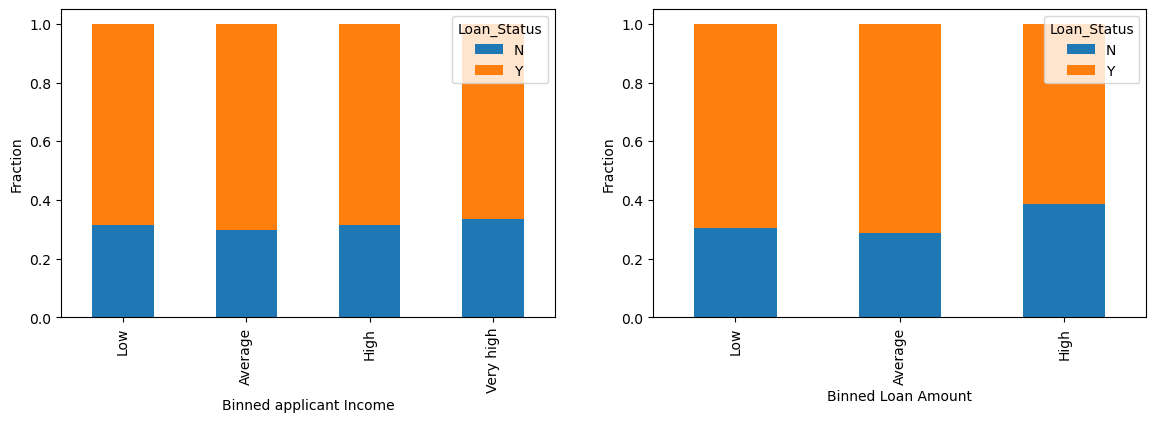

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Discretised Applicant income vs. Loan Status

bins=[0,2500,4000,6000,81000]  # boundaries for the bins
labels=['Low','Average','High','Very high']  # names for the bins
df['Income_bin']=pd.cut(df['ApplicantIncome'],bins,labels=labels) #  add discretised values as new column

Income_bin=pd.crosstab(df['Income_bin'],df['Loan_Status'])  # get value combination counts
Income_bin = Income_bin.div(Income_bin.sum(1).astype(float), axis=0)  # normalise counts
Income_bin.plot(kind="bar",stacked=True, ax=axes[0], xlabel="Binned applicant Income", ylabel="Fraction")
print(df.describe())
bins = [0,100,200,700]  # boundaries for the bins
labels = ['Low','Average','High']  # names for the bins
df['LoanAmount_bin']=pd.cut(df['LoanAmount'],bins,labels=labels)  # add discretised values as new column
print(df['LoanAmount_bin'].value_counts())

LoanAmount_bin=pd.crosstab(df['LoanAmount_bin'],df['Loan_Status']) # get value combination counts
LoanAmount_bin = LoanAmount_bin.div(LoanAmount_bin.sum(1).astype(float), axis=0)  # normalise counts
LoanAmount_bin.plot(kind="bar",stacked=True, ax=axes[1], xlabel="Binned Loan Amount", ylabel="Fraction")

plt.show()

## 3. Preprocessing data using Pandas
### 3.1 Missing value imputation

* ***df*.isnull()** identifies missing values
* ***series*.mode()** finds most common categorical value
* ***series*.mean()** finds mean of numeric values
* ***series*.fillna(*value*)** replaces missing values with a value


In [36]:
# count the null/NaN/missing values for each variable
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
Income_bin            0
LoanAmount_bin       22
dtype: int64

In [37]:
# fill the missing values in categorical variables with the mode/most frequent state in that column

df['Gender'] = df["Gender"].fillna(df['Gender'].mode()[0])
df['Married'] = df["Married"].fillna(df['Married'].mode()[0])
df['Dependents'] = df["Dependents"].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])
df['LoanAmount_bin'] = df['LoanAmount_bin'].fillna(df['LoanAmount_bin'].mode()[0])

In [38]:
# fill the missing values in numerical variables with the mean value of that column

df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean())

In [39]:
df.isnull().sum() # We have successfully replaced all missing values
df_original = df.copy()

### 3.2 *Consider* adjusting distributions of continuous variables

* as we saw above, some distributions were quite skewed - we could try making them more like normal (some machine learning algorithms might prefer this)
* can experiment with using np.log() to make the distribution 'more' Gaussian

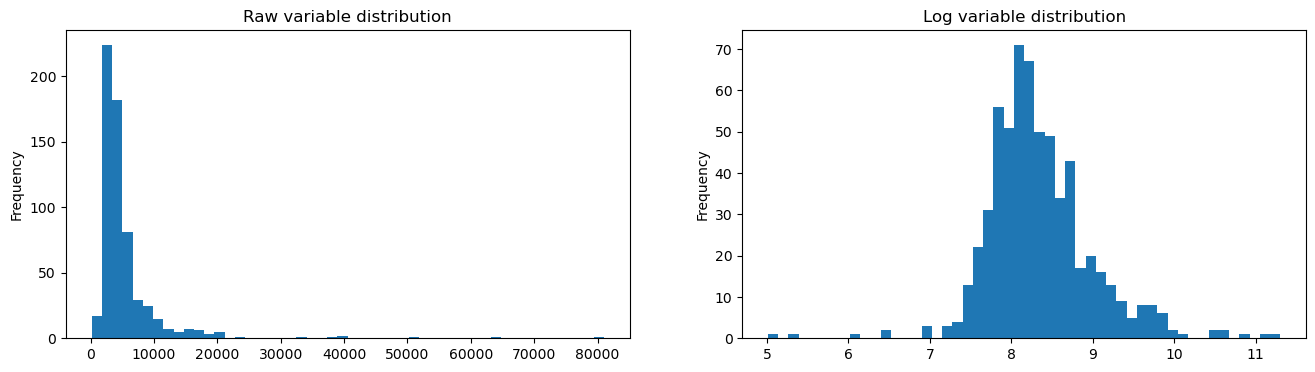

In [41]:
 # get the logarithmic scale of each variable not normally distributed
 # the "replace(0, 1)"" ensures we don't try to take the log of zero.

df['ApplicantIncomeLog'] = np.log(df['ApplicantIncome'])
df['CoapplicantIncomeLog'] = np.log(df['CoapplicantIncome'].replace(0, 1))
df['LoanAmountLog'] = np.log(df['LoanAmount'])
df['Loan_Amount_Term_Log'] = np.log(df['Loan_Amount_Term'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
df['ApplicantIncome'].plot(kind='hist', bins=50, ax=axes[0], title='Raw variable distribution')
df['ApplicantIncomeLog'].plot(kind='hist', bins=50, ax=axes[1], title='Log variable distribution')
plt.show()

### 3.3 *Consider* creating composite variables that might be more predictive

In [43]:
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Total_Income_Log'] = np.log(df['Total_Income'])

In [44]:
df.head() # Let's view the data set again - notice the categories are now integer values

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income_bin,LoanAmount_bin,ApplicantIncomeLog,CoapplicantIncomeLog,LoanAmountLog,Loan_Amount_Term_Log,Total_Income,Total_Income_Log
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,High,Average,8.674026,0.000000,4.986426,5.886104,5849.0,8.674026
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,High,Average,8.430109,7.318540,4.852030,5.886104,6091.0,8.714568
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,Average,Low,8.006368,0.000000,4.189655,5.886104,3000.0,8.006368
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,Average,Average,7.856707,7.765569,4.787492,5.886104,4941.0,8.505323
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,High,Average,8.699515,0.000000,4.948760,5.886104,6000.0,8.699515


### 3.4 Convert categorical variables to integer ones

* use **df.astype({*'colnam1'*: int, ...})** as most machine learning algorithms require numeric input
* You can alternatively use Scikit-learn's **LabelEncoder()** from **sklearn.preprocessing** module to convert categorical values to integer ones

In [46]:
print('Gender is originally a string variable:\n{}'.format(df['Gender'].value_counts()))
df['Gender'] = df['Gender'].astype('category').cat.codes
print('\nGender is converted to integer:\n{}'.format(df['Gender'].value_counts()))

# do the rest of the categorical variables

df['Married'] = df['Married'].astype('category').cat.codes
df['Dependents'] = df['Dependents'].astype('category').cat.codes
df['Education'] = df['Education'].astype('category').cat.codes
df['Self_Employed'] = df['Self_Employed'].astype('category').cat.codes
df['Credit_History'] = df['Credit_History'].astype('category').cat.codes
df['Property_Area'] = df['Property_Area'].astype('category').cat.codes
df['Loan_Status'] = df['Loan_Status'].astype('category').cat.codes
df['Income_bin'] = df['Income_bin'].astype('category').cat.codes
df['LoanAmount_bin'] = df['LoanAmount_bin'].astype('category').cat.codes

print('\nData frame with categorical variables converted to integers:')
df.head()

Gender is originally a string variable:
Gender
Male      502
Female    112
Name: count, dtype: int64

Gender is converted to integer:
Gender
1    502
0    112
Name: count, dtype: int64

Data frame with categorical variables converted to integers:


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income_bin,LoanAmount_bin,ApplicantIncomeLog,CoapplicantIncomeLog,LoanAmountLog,Loan_Amount_Term_Log,Total_Income,Total_Income_Log
0,1,0,0,0,0,5849,0.0,146.412162,360.0,1,2,1,2,1,8.674026,0.000000,4.986426,5.886104,5849.0,8.674026
1,1,1,1,0,0,4583,1508.0,128.000000,360.0,1,0,0,2,1,8.430109,7.318540,4.852030,5.886104,6091.0,8.714568
2,1,1,0,0,1,3000,0.0,66.000000,360.0,1,2,1,1,0,8.006368,0.000000,4.189655,5.886104,3000.0,8.006368
3,1,1,0,1,0,2583,2358.0,120.000000,360.0,1,2,1,1,1,7.856707,7.765569,4.787492,5.886104,4941.0,8.505323
4,1,0,0,0,0,6000,0.0,141.000000,360.0,1,2,1,2,1,8.699515,0.000000,4.948760,5.886104,6000.0,8.699515


## 4. Feature Selection

### 4.1 Look at correlations between each pair of variables using Pandas

Let's view the correlation between every pair of variables using Pandas
 * used ***dataframe*.corr()** - note only looks at numeric variables, so do this after you've converted categorical variables to integer

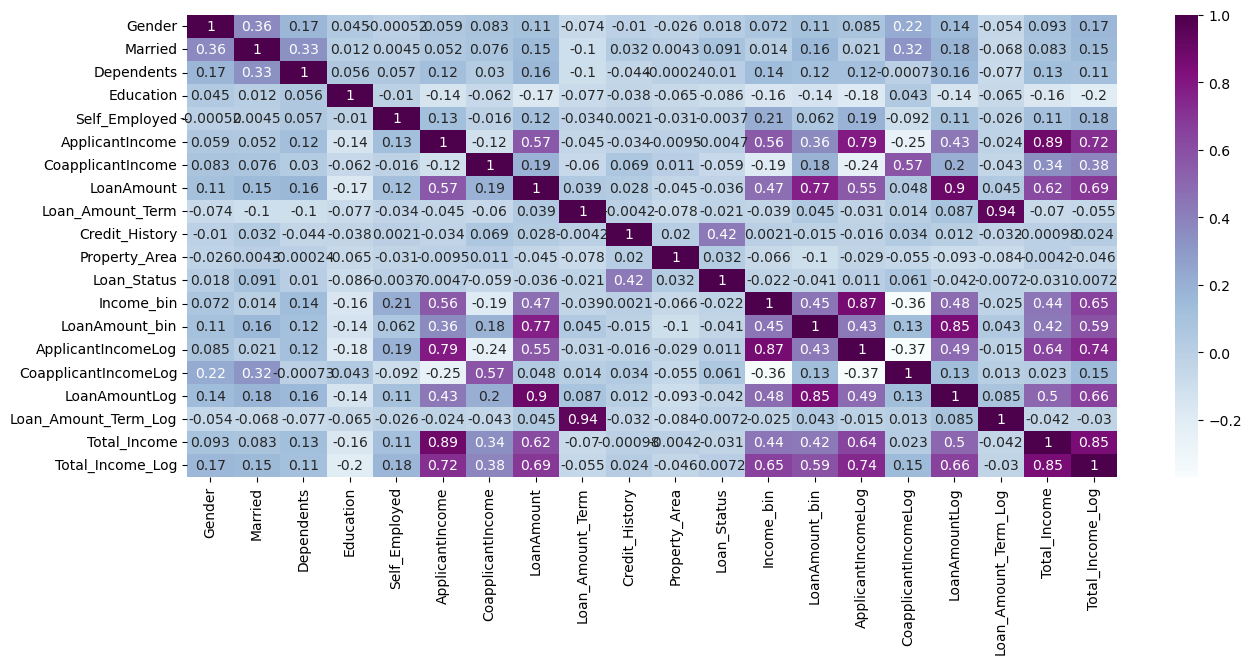

In [48]:
corr=df.corr() # gives us the correlation values
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot = True, cmap="BuPu")  # let's visualise the correlation matrix
plt.show()


**Question (optional, to think about): Which of these suggestions about the correlations is true?**
 1. Consider dropping Credit_History as it is quite strongly correlated with Loan_Status
    - INCORRECT: It is true that Credit_History is strongly correlated with the target
variable Loan_Status but this means we don’t want to drop it as it means it is likely
to be a good predictor of loan_status
 2. Consider dropping Education as it is negatively correlated with Loan_Status
    - INCORRECT: Education is strongly negatively correlated with Loan_Status - “neg-
ative” means as Education increases the person is less likely to be offered a loan - but
the fact it is negative doesn’t matter, it still affects the target variable Loan_Status
and so should not be dropped.
 3. Consider dropping LoanAmount as it is quite strongly correlated with LoanAmountLog
    - CORRECT: LoanAmount and LoanAmountLog are both feature variables, and be-
cause they are strongly correlated it suggests that they may be just duplicating the
same information. So, it could be useful to consider dropping one of them to reduce
the number of feature variables without worsening the quality of prediction.

Let's drop some feature variables that seem to be highly correlated with other features and are therefore maybe not providing any useful extra information.

In [51]:
# Let's drop the six features below
cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Total_Income', 'CoapplicantIncomeLog']
df = df.drop(columns=cols,axis=1)

### 4.2 Look at how strongly the remaining feature variables are associated with the target variable using Scikit-learn

This is an alternative/additional way of choosing some feature variables to drop using Scikit-Learn methods. The intuition is that feature variables which are not strongly associated with the target variable won't be very useful in predicting it and so are candidates to be dropped.

In [53]:
# Split dataframe into feature variable inputs 'X' dataframe, and output target variable 'y' Series

X = df.drop(['Loan_Status'],axis=1)
y = df['Loan_Status']

The first two methods below measure correlation between each feature variable and the target variable, but you can specify the correlation test. The chi2 (chi-squared) test is a standard linear correlation test, whereas the ftest is better at spotting non-linear correlations.

The **SelectKBest** method just returns the 'k' variables most highly correlated with the target, but here we are choosing to retrun them all.

In [55]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif

# let's call the k-best method with Chi-squared score and pass X and y as inputs

chi2 = SelectKBest(score_func = chi2, k = 'all').fit(X,y)

# create Series with variable name as index, and scores as values, and sort lowest to highest ready for plotting

chi2_sorted = pd.Series(data=chi2.scores_, index=X.columns).sort_values()

# Repeat but with other scoring functions

ftest = SelectKBest(score_func = f_classif, k = 'all').fit(X,y)
ftest_sorted = pd.Series(data=ftest.scores_, index=X.columns).sort_values()

mitest = SelectKBest(score_func = mutual_info_classif, k = 'all').fit(X,y)
mitest_sorted = pd.Series(data=mitest.scores_, index=X.columns).sort_values()

Instead of using correlation tests to show how strongly feature variables are associated with the target variable we can use some machine learning approaches which provide information about how strongly each target variable **as a by-product** of learning a predictive model. Here we use the ExtraTreesClassifier and MutualInformationClassifier.

In [57]:
from sklearn.ensemble import ExtraTreesClassifier # this is a method alternative to k-best

xtrees = ExtraTreesClassifier().fit(X, y)
xtrees_sorted = pd.Series(data=xtrees.feature_importances_, index=X.columns).sort_values()
from sklearn.feature_selection import mutual_info_classif

muinfo = mutual_info_classif(X,y)
muinfo_sorted = pd.Series(data=muinfo, index=X.columns).sort_values()

Let's plot out the strength of association of the feature variables with the target variable using the four methods we've just run.

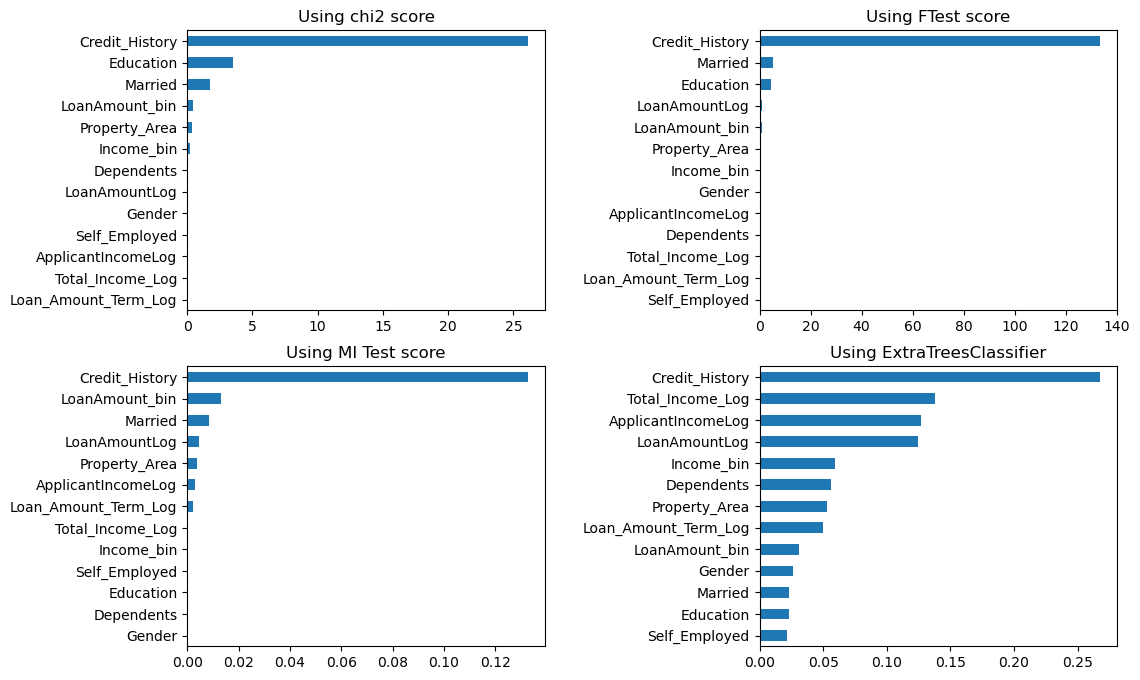

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.6)
chi2_sorted.plot(kind='barh', ax=axes[0, 0], title='Using chi2 score')
ftest_sorted.plot(kind='barh', ax=axes[0, 1], title='Using FTest score')
xtrees_sorted.plot(kind='barh', ax=axes[1, 1], title='Using ExtraTreesClassifier')
mitest_sorted.plot(kind='barh', ax=axes[1, 0], title='Using MI Test score')
plt.show()

**Question (optional, to think about): Which of these statements about the above charts is true?**
 1. Credit_History gets a high score on all measures and so is not very predictive and should be dropped
    - INCORRECT: No, the opposite is true. The high scores for Credit_History mean
that is likely a good predictor of Loan_Status and should not be dropped.
 2. MI Test Scores and ExtraTreesClassifier give low values and should be ignored
    - INCORRECT: The different scores shown in the charts may have different ranges,
e.g. chi2 goes from 0 to 25, whereas MI goes from 0.0 to 0.15 but this is irrelevant as
they are different kinds of scores, and doesn’t mean anyone is more useful than the other.
 3. The different scores give quite different pictures of which are the most predictive feature variables
    - CORRECT: This is correct. All four of the scores show that Credit_History is likely
the most predictive variable, but the order of the other variables is different for each
score.


Except for Credit_History always being most strongly associated with Loan_status these four approaches don't have much else in common, so let's not delete any more feature variables.

### 4.3 More Systematic Approaches to Feature Selection

We're not doing it in this case study, and you certainly don't need to do it the coursework, but a more systematic approach is to start with the best single feature variable and then progressively add features until the accuracy no longer improves significantly, or alternatively, start with all features and progressively remove features until the accuracy starts to drop off.

## 5. Prediction and Evaluation using Scikit-Learn

In [64]:
# for this, we will import another library so that we don`t have to code everything from scratch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, \
    recall_score, confusion_matrix
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

In [65]:
def train_and_evaluate(model, X, y):
    """
        Train and evaluate a classification model on training data
        and produce accuracy metrics for a separate test set.
    """

    print('\nResults from algorithm {}:'.format(model))

    # Split data into train and test - we will use test for the final accuracy metrics
    # and not use it to train the model. This is good practice, particularly when you are
    # using cross-validation to select model parameters ... that way, the characteristics
    # of the test data don't leak into the model training
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Cross-validation accuracy gives an indication of variation in accuracy and a better
    # estimate for overall accuracy than just a single estimate. The mean cross-validation
    # accuracy is therefore a better guide when selecting model parameters or comparing models
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print('Mean cross-validation accuracy is {:.3f} with SD {:.3f}'
          .format(np.mean(scores), np.std(scores)))

    # Fit model using all of the reserved training data ... look at training accuracy 
    # which we generally expect to be better than test accuracy

    learnt_model = model.fit(X_train, y_train)
    print('\nAccuracy on training data is {:.3f}\n'.format(model.score(X_train, y_train)))
    
    # User predict() to predict target values from test feature variables, and then
    # use functions to compute evaluation metrics relevant to binary outcome variable

    y_pred = model.predict(X_test)
    print('Test data metrics: accuracy={:.3f}, f1={:.3f}, precision={:.3f}, recall={:.3f}'
          .format(accuracy_score(y_true=y_test, y_pred=y_pred),
                  f1_score(y_true=y_test, y_pred=y_pred),
                  precision_score(y_true=y_test, y_pred=y_pred),
                  recall_score(y_true=y_test, y_pred=y_pred)))
    
    # Draw out a confusion matrix
    
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    plt.figure(figsize=(2, 2))
    ax = sns.heatmap(cm,annot=True, xticklabels=['N', 'Y'], cbar=False,
                     yticklabels=['N', 'Y'], square=True,
                     linewidths=8.0) # plots the confusion matrix
    ax.set_xlabel('Predicted Loan Status')
    ax.set_ylabel('Actual Loan Status')
    plt.show()
    
    return learnt_model



Results from algorithm LogisticRegression(max_iter=200):
Mean cross-validation accuracy is 0.811 with SD 0.023

Accuracy on training data is 0.817

Test data metrics: accuracy=0.789, f1=0.859, precision=0.760, recall=0.988


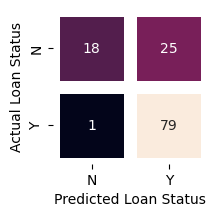

In [66]:
# let's try logistic regression (need more than 100 iterations to avoid convergence failure warning)

from sklearn.linear_model import LogisticRegression
_ = train_and_evaluate(LogisticRegression(max_iter=200), X, y)

**Question (optional, to think about): which of these options about the Logistic Regression results is correct?**

 1. Accuracy on training data is higher than test data which is surprising
    - INCORRECT: No, accuracy is usually higher on training data than test data.
 2. Recall is very high which means it nearly always identifies when a person was actually given a loan
    - CORRECT: Looking at the Confusion Matrix we see that the model predicts that 78
people get a loan out of the 79 (= 78 + 1) that actually do - so it does have very high
Recall.
 3. Accuracy is nearly 80% so this is a good predictor of when someone is refused a loan
    - INCORRECT: Although the accuracy looks good, if we look at the confusion matrix,
we see that of the 43 ( = 18 + 25 ) who were actually refused a loan, the learnt model
wrongly predicts that 25 of them would be given a loan. So it is not a good predictor
of when a person is refused a loan.


Results from algorithm KNeighborsClassifier():
Mean cross-validation accuracy is 0.735 with SD 0.034

Accuracy on training data is 0.811

Test data metrics: accuracy=0.732, f1=0.825, precision=0.716, recall=0.975


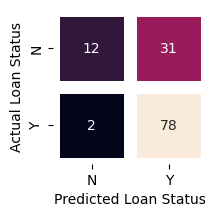

In [68]:
# and now try K-nearest neighbour

from sklearn.neighbors import KNeighborsClassifier
_ = train_and_evaluate(KNeighborsClassifier(), X, y)


Results from algorithm DecisionTreeClassifier():
Mean cross-validation accuracy is 0.729 with SD 0.038

Accuracy on training data is 1.000

Test data metrics: accuracy=0.691, f1=0.765, precision=0.756, recall=0.775


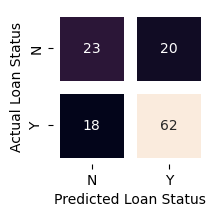

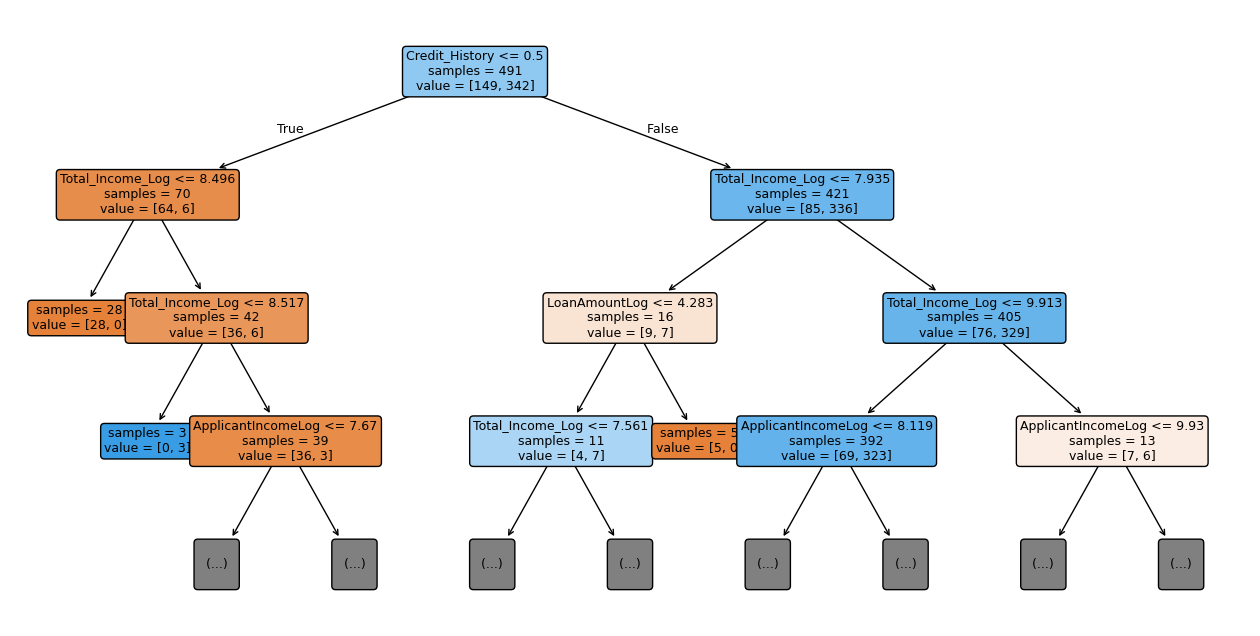

In [69]:
# and finally a decision tree

from sklearn.tree import DecisionTreeClassifier, plot_tree
learnt_model = train_and_evaluate(DecisionTreeClassifier(), X, y)
plt.figure(figsize=(16, 8))
plot_tree(learnt_model, max_depth=3, feature_names=list(X.columns),
          fontsize=9, filled=True, impurity=False, rounded=True)
plt.show()

**Question (optional, to think about): which of these options about Decision Trees is correct?**

 1. Credit_History is at the top of decision tree so it is likely one of the better predictive variables
    - CORRECT: Yes, this is correct, the most predictive variables tend to be at the top of
the decision tree.
 2. Training accuracy for Decision Trees was 100% indicating this is a very good classifier
    - INCORRECT: The accuracy on the test data is the important consideration, not on
training data.
 3. Test accuracy of Decision Trees was  0.699 compared to 0.789 for LogisticRegression so DecisionTrees is worse at predicting loan rejection
    - INCORRECT: Although it is less accurate, Decision Trees is better at predicting Loan
rejection - getting 23 / 43 correct, compared to 18 / 43 with Logistic Regression.

## 6. Select best hyperparameter values using cross-validation

This demonstrates selecting best hyperparameters using cross-validation, and then reporting accuracy using a test dataset which wasn't used to select the hyperparameter. This is considered good practice. Here, we are trying to find the best value for the regularisation strength in LogisticRegression - lower vaues for this constant represent stronger regularisation.

You could take more sophisticated approaches like varying several hyperparameters and seeing which combination of hyperparameters is best, or vary both the algorithm and hyperparameters, but the approach here is sufficient for a high mark in the coursework.


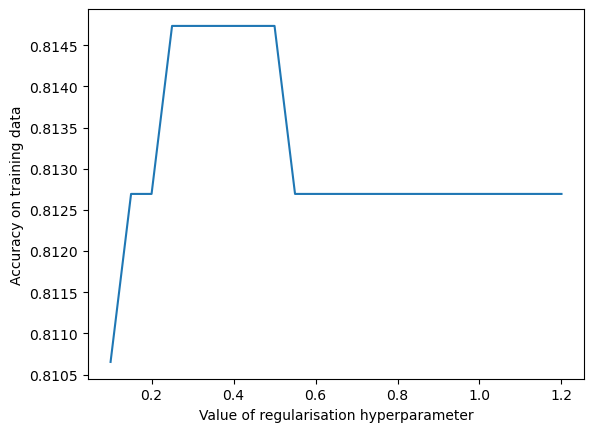

In [72]:
def train_model(algorithm, hyperparams, X, y):
    """
        Use cross-validation to determine model accuracy for a 
        specified algorithm, hyperparameters, features and target
        variables.
        
        :param Scikit-Learn class algorithm: name of constructor for algorithm
        :param dict hyperparameters: hyperparameters passed to constructor- keys must 
                                     be parameters allowed for constructor
        :param array-like X: values of feature variables
        :param vector-like y: values of target variables
        
        :returns tuple: mean accuracy across all CV folds, and trained model
    """
    # Instantiate the specified model using the specified hyperparameter values

    model = algorithm(**hyperparams)

    # Perform cross-validation over the data to get a good view of accuracy
    
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')

    # Fit model to supplied data

    learnt_model = model.fit(X, y)

    # return mean accuracy over all CV folds

    return (np.mean(scores), learnt_model)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Let's try a range of regularisation strengths 0.1, 0.15 ... 1.2

reg_values = [0.05 * i for i in range(2, 25)]
reg_accuracy = []
for reg_strength in reg_values:
    acc, _ = train_model(LogisticRegression, {'C': reg_strength, 'max_iter': 200}, X_train, y_train)
    reg_accuracy.append(acc)

# Plot the results

plt.plot(reg_values, reg_accuracy) #plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Accuracy on training data')
plt.xlabel('Value of regularisation hyperparameter');
plt.show()


It looks like a regularisation value around 0.35 might be best - note, that this is stronger regularisation than the default value of 1.0. Finally, let's check the accuracy of the model using this hyperparameter on the test set which we kept aside from the hyperparameter selection.

In this case the small improvements in accuracy that selecting the best regularisation parameter for the training data didn't translate into any improvement in accuracy on the test data set, but often it would.

Test data metrics: accuracy=0.789, f1=0.859, precision=0.760, recall=0.988


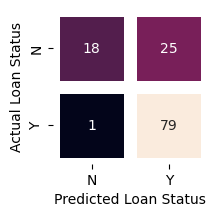

In [74]:
# train model again with the best hyperparameter value

train_accuracy, best_model = train_model(LogisticRegression, {'C': 0.35, 'max_iter': 200}, X_train, y_train)

# ... and check its accuracy on the test set

y_pred = best_model.predict(X_test)
print('Test data metrics: accuracy={:.3f}, f1={:.3f}, precision={:.3f}, recall={:.3f}'
      .format(accuracy_score(y_true=y_test, y_pred=y_pred),
              f1_score(y_true=y_test, y_pred=y_pred),
              precision_score(y_true=y_test, y_pred=y_pred),
              recall_score(y_true=y_test, y_pred=y_pred)))
    
# Draw out a confusion matrix
    
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plt.figure(figsize=(2, 2))
ax = sns.heatmap(cm,annot=True, xticklabels=['N', 'Y'], cbar=False,
                 yticklabels=['N', 'Y'], square=True,
                 linewidths=8.0) # plots the confusion matrix
ax.set_xlabel('Predicted Loan Status')
ax.set_ylabel('Actual Loan Status')
plt.show()


## 7. Feature Reduction using PCA

This could be an alternative to feature selection ... let's first revert back to the data set just after we had imputed the missing values, and remove some columns we had added ...

In [76]:
df = df_original.copy().drop(['Income_bin', 'LoanAmount_bin'], axis='columns')

Convert categorical variables to integers again but this time use Scikit-learn's LabelEncoder to do this just to illustrate this method. Also split the target variable off into its own vector so we can feed feature variables into PCA and machine learning methods.

In [78]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
cols = ['Gender','Married', 'Dependents', 'Education', 'Self_Employed', 
        'Property_Area','Loan_Status', 'Credit_History']
le = LabelEncoder()                       # initialise the necessary function taken from the LabelEncoder library
for col in cols:                          # iterate over all variables in cols
    df[col] = le.fit_transform(df[col])   # convert categorical values into integer values

X = df.drop(['Loan_Status'],axis=1)
y = df['Loan_Status']

print(X.head())

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)


   Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0       1        0           0          0              0             5849   
1       1        1           1          0              0             4583   
2       1        1           0          0              1             3000   
3       1        1           0          1              0             2583   
4       1        0           0          0              0             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0  146.412162             360.0               1   
1             1508.0  128.000000             360.0               1   
2                0.0   66.000000             360.0               1   
3             2358.0  120.000000             360.0               1   
4                0.0  141.000000             360.0               1   

   Property_Area  
0              2  
1              0  
2              2  
3              2  
4              2  


Run PCA with 10 components so we can plot the amount of variance in the feature variables explained by the first ten components.

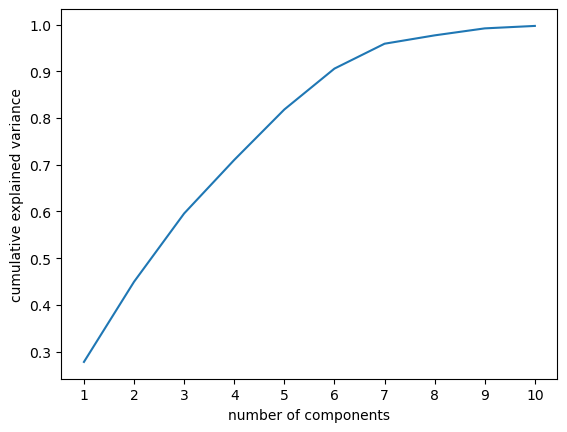

In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10).fit(X)
plt.plot(range(1,11), np.cumsum(pca.explained_variance_ratio_)) #plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(1,11))  
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

Looks like around 7 might be a good number of components as the curve bends most there .... lets use 6 components and check the accuracy on training and test datasets ...


PCA reduces features from (614, 11) to (614, 6)

Results from algorithm LogisticRegression():
Mean cross-validation accuracy is 0.697 with SD 0.004

Accuracy on training data is 0.697

Test data metrics: accuracy=0.650, f1=0.788, precision=0.650, recall=1.000


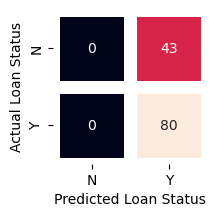

In [82]:
pca = PCA(n_components=6).fit(X)
X_reduc = pca.transform(X)
print('\nPCA reduces features from {} to {}'.format(X.shape, X_reduc.shape))
learnt_model = train_and_evaluate(LogisticRegression(), X_reduc, y)

**Question (optional, to think about): Comparing this to LogisticRegression without PCA, which of these options is correct?**

 1. PCA with 6 components does not seem to have improved the analysis
    - CORRECT: This is true, in fact it is a very poor classifier.
 2. The confusion matrix strongly distinguishes between Predicted Loan Status of 'N' and 'Y' so this is a very good result
    - INCORRECT: It does strongly distingiush between Predicted Loan Status of ‘N’ and
‘Y’ but only in the sense that it always predicts the person will be given a loan - that
is, it is a very poor predictor.
 3. PCA has reduced the number of dimensions from 11 to 6 and still achieves perfect recall so PCA with 6 components is very useful for this analysis.
    - INCORRECT: It does have perfect Recall in that it always predicts that people but
will be given a loan when this is actually the case, but the big problem is that it predicts
everyone will be given a loan.

Let's see if 7 components is better ...


PCA reduces features from (614, 11) to (614, 9)

Results from algorithm LogisticRegression():
Mean cross-validation accuracy is 0.815 with SD 0.021

Accuracy on training data is 0.815

Test data metrics: accuracy=0.789, f1=0.859, precision=0.760, recall=0.988


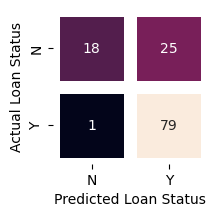

In [85]:
pca = PCA(n_components=9).fit(X)
X_reduc = pca.transform(X)
print('\nPCA reduces features from {} to {}'.format(X.shape, X_reduc.shape))
learnt_model = train_and_evaluate(LogisticRegression(), X_reduc, y)